In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel

In [3]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    s2 = Q/N
    vs2 = s2/N
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    vB = (1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr)/tmp
    return s2,vs2,B,vB

def OUresult(data,deltat):
    s2, vs2, B ,vB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*np.sqrt(vB)/B/np.log(B)**2
    return s2,np.sqrt(vs2),tau,dtau

In [4]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [21]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

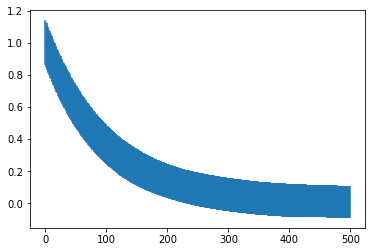

In [22]:
plt.errorbar(t,acf_mean,yerr=acf_std)

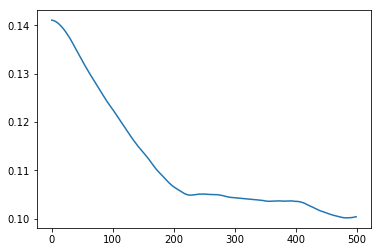

In [23]:
plt.plot(t,acf_std)

In [24]:
acf_all[0].size

500

In [25]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[0,0])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[1,1])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[0,0])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[1,1])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.091
    reduced chi-square = 0.002
    Akaike info crit   = -3057.531
    Bayesian info crit = -3049.102
[[Variables]]
    amplitude:   0.99853218 +/- 0.010673 (1.07%) (init= 0.1747871)
    decay:       74.9436702 +/- 1.140703 (1.52%) (init= 165.6882)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 94.189
    reduced chi-square = 0.189
    Akaike info crit   = -828.650
    Bayesian info crit = -820.221
[[Variables]]
    amplitude:   1.01588090 +/- 0.013639 (1.34%) (init= 0.1747871)
    decay:       72.5211916 +/- 1.244643 (1.72%) (init= 165.6882)
[[Correlations]] (unreported correlations a

(array([ 0.1078483 ,  0.76572295,  1.9628391 ,  2.6422834 ,  2.63149857,
         1.40202793,  0.90592574,  0.2480511 ,  0.07549381,  0.04313932]),
 array([ 0.62327323,  0.71599606,  0.8087189 ,  0.90144173,  0.99416456,
         1.08688739,  1.17961022,  1.27233306,  1.36505589,  1.45777872,
         1.55050155]),
 <a list of 10 Patch objects>)

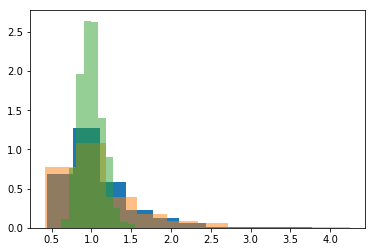

In [27]:
# decay time
plt.hist(result_array.T[0],normed=True)
plt.hist(result_array.T[4],normed=True,alpha=0.5)
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5)

(array([  13.,   75.,  187.,  247.,  236.,  129.,   78.,   25.,    6.,    4.]),
 array([ 0.63558867,  0.72639828,  0.81720789,  0.9080175 ,  0.99882711,
         1.08963671,  1.18044632,  1.27125593,  1.36206554,  1.45287515,
         1.54368476]),
 <a list of 10 Patch objects>)

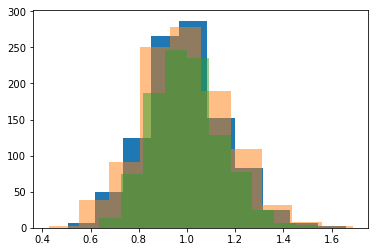

In [29]:
# amplitude
plt.hist(result_array.T[2])
plt.hist(result_array.T[6],alpha=0.5)
plt.hist(result_Bayes_array.T[0],alpha=0.5)